In [205]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [206]:
data_path = r"data1.csv"
new_york_data_path = r"Borough Boundaries.geojson"

In [207]:
data = pd.read_csv(data_path, encoding='utf-8', sep=',')

In [208]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [209]:
len(data.index), len(data.host_id.unique())

(48895, 37457)

#### records count per host id 

In [210]:
value_counts = data.host_id.value_counts().sort_values(ascending=False)

In [211]:
cumulative_counts = value_counts.cumsum()

In [212]:
cumulative_counts = value_counts.cumsum()
cumulative_percentages = cumulative_counts / cumulative_counts.max()

Text(0, 0.5, '%')

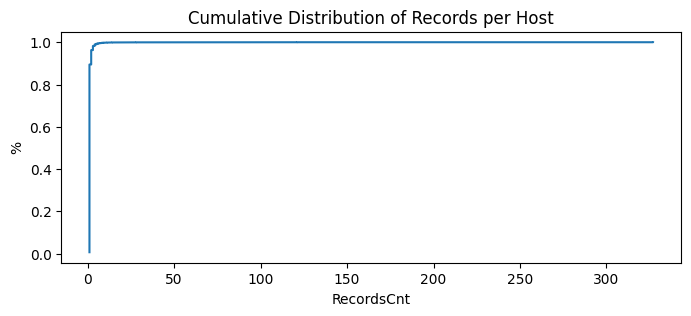

In [213]:
plt.figure(figsize=(8,3))
plt.step(value_counts.sort_values(ascending=True), cumulative_percentages, where='post')
plt.title('Cumulative Distribution of Records per Host')
plt.xlabel('RecordsCnt')
plt.ylabel('%')

Marginal amount of hosts are reprezented by more that one record in dataset. Their Airbnbs were booked once in given period of time (assuming that data refer to some given period)

#### vizualization of location data

In [214]:
geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]

gdf = gpd.GeoDataFrame(data, geometry=geometry)
gdf.set_crs(epsg=2263, inplace=True)
gdf.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,POINT (-73.972 40.647)
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,POINT (-73.984 40.754)
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,POINT (-73.942 40.809)
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,POINT (-73.96 40.685)
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,POINT (-73.944 40.799)


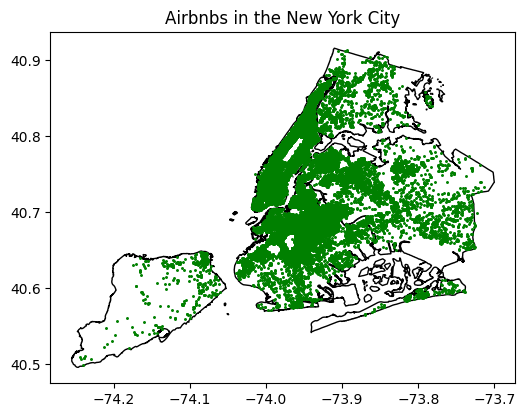

In [215]:
url = "https://raw.githubusercontent.com/dwillis/nyc-maps/master/boroughs.geojson"
nyc_gdf = gpd.read_file(url)

# Plot the NYC boundaries
fig, ax = plt.subplots(figsize=(6, 6))
nyc_gdf.plot(ax=ax, edgecolor='black', facecolor='none')

gdf.plot(ax=ax, marker='.', markersize=5, color='green')
plt.title('Airbnbs in the New York City')
plt.show()

#### Taget analysis

In [216]:
data.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

Removing from data rooms with price per night equals 0 

In [217]:
data = data.loc[data.price > 0]
gdf = gdf.loc[gdf.price > 0]

<Axes: >

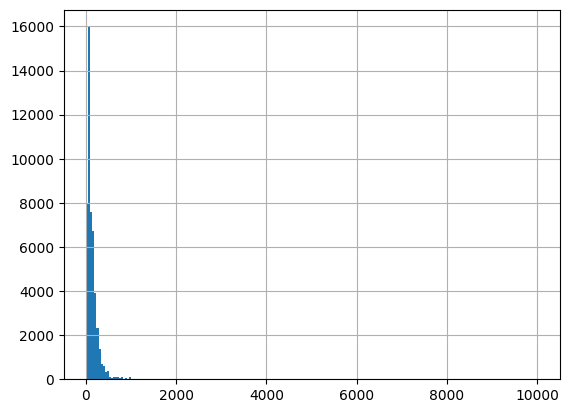

In [218]:
data.price.hist(bins=int(np.sqrt(len(data.index))))

Plotting prices with removed listing with abnormally high prices

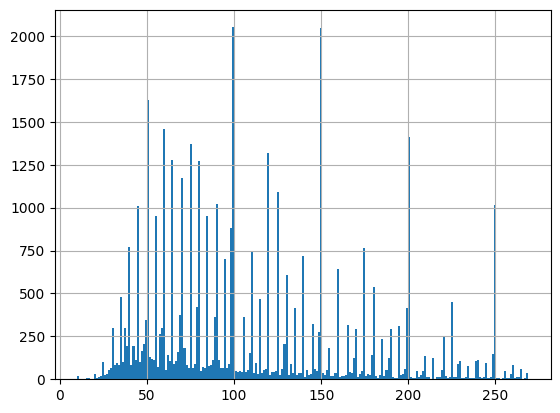

In [219]:
Q3 = data['price'].quantile(0.9)
filtered_data = data[data['price'] <= Q3].price.hist(bins=int(np.sqrt(len(data.index))))

Adding price per night as a color scale for visualization

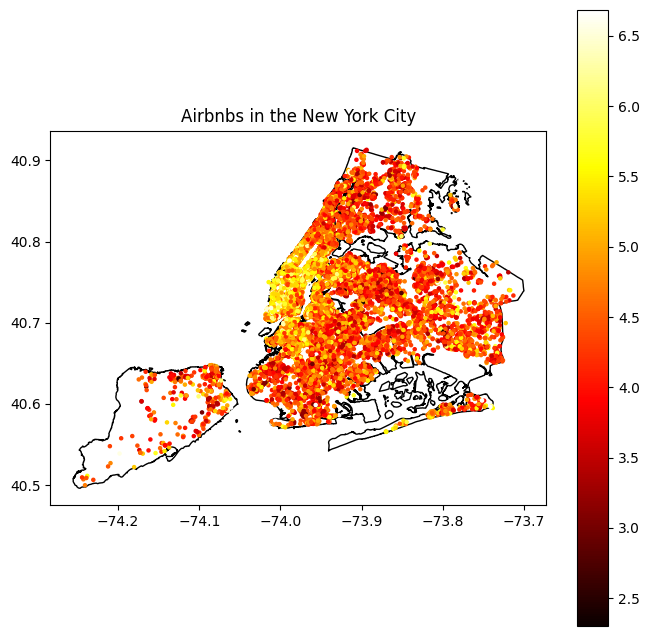

In [220]:
# Plot the NYC boundaries
fig, ax = plt.subplots(figsize=(8, 8))
nyc_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
gdf['log_price'] = np.log(gdf['price'])
gdf.plot(ax=ax, marker='.', markersize=20,  column='log_price', cmap='hot', legend=True, vmin=gdf.log_price.min(), vmax=gdf.log_price.quantile(0.99))
plt.title('Airbnbs in the New York City')
plt.show()

### Features

In [221]:
'; '.join(x for x in data.columns.tolist())

'id; name; host_id; host_name; neighbourhood_group; neighbourhood; latitude; longitude; room_type; price; minimum_nights; number_of_reviews; last_review; reviews_per_month; calculated_host_listings_count; availability_365'

Variables: id, name, host_id are related are identifiers or non-informative features that don't carry meaningful patterns related to the target variable, so they shouldn't be used in any model.

In [222]:
feature_columns = [x for x in data.columns.tolist() if x not in ['id', 'name', 'host_id', 'host_name', 'price', 'log_price']]

In [223]:
target_column = 'price'

In [224]:
data_types = data[feature_columns].dtypes.to_dict()

First let's prepare numerical variables for modeling

In [225]:
numerical_features = [k for k, v in data_types.items() if v != 'object']

In [226]:
numerical_features

['latitude',
 'longitude',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

Checking if there are any null among numerical values

In [227]:
data[numerical_features].isnull().sum()

latitude                              0
longitude                             0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10051
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [228]:
data.loc[data.reviews_per_month.isna()][['number_of_reviews', 'reviews_per_month']].head(5)

,number_of_reviews,reviews_per_month
2,0,NaN
19,0,NaN
26,0,NaN
36,0,NaN
38,0,NaN


If there is an Airbnb without reviews, the reviews_per_month is set to null. Blanks will be filled with 0.

In [229]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

In [230]:
corr = data[numerical_features+[target_column]].corr()

Text(0.5, 1.0, 'Correlation Heatmap')

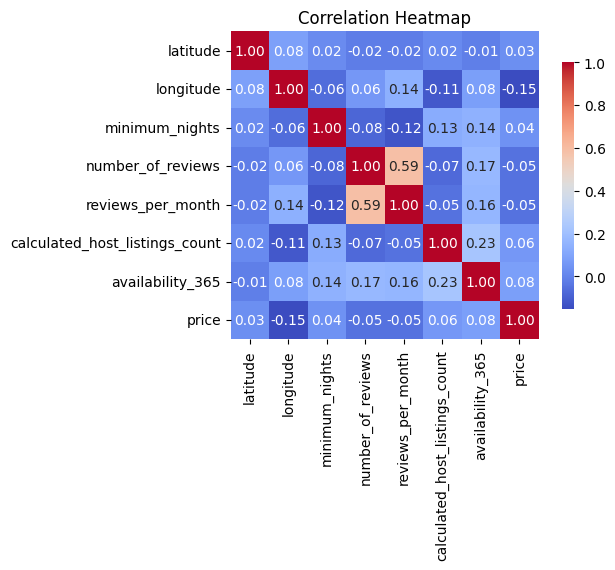

In [231]:
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap')

Non of the numerical variables are strongly correlated with the target.

Numerical values are going to be used without further preprocessing in model.

Checking and preprocessing non numerical data.

In [232]:
non_numerical_features = [k for k, v in data_types.items() if v == 'object']

In [233]:
non_numerical_features

['neighbourhood_group', 'neighbourhood', 'room_type', 'last_review']

Last review won't be used in further modeling. It's highly probable that this var is  irrelevant for predicting outcome.

In [234]:
print('Available room types: ', data.room_type.unique())

Available room types:  ['Private room' 'Entire home/apt' 'Shared room']


In [235]:
print('City districts: ', data.neighbourhood_group.unique())

City districts:  ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']


Variables neighbourhood_group and room_type have small nb of unique values, one-hot encoding can be used to encoding data without increasing dimensionality to much

In [236]:
print(len(data.neighbourhood.unique()))

221


Due to many uniqual values of neighbourhood var frequency encoding will be used.

#### Encoding categorical variables.

In [237]:
data['neighbourhood_encoded'] = data['neighbourhood'].map(data['neighbourhood'].value_counts())

In [238]:
data = pd.get_dummies(data, columns=['neighbourhood_group', 'room_type'], drop_first=True, dtype=int)

In [239]:
data.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_encoded',
       'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')

In [240]:
encoded_columns = ['neighbourhood_encoded'] + [col for col in data.columns if col.startswith('neighbourhood_group')] + [col for col in data.columns if col.startswith('room_type')]

In [241]:
corr = data[encoded_columns+[target_column]].corr()

Text(0.5, 1.0, 'Correlation Heatmap')

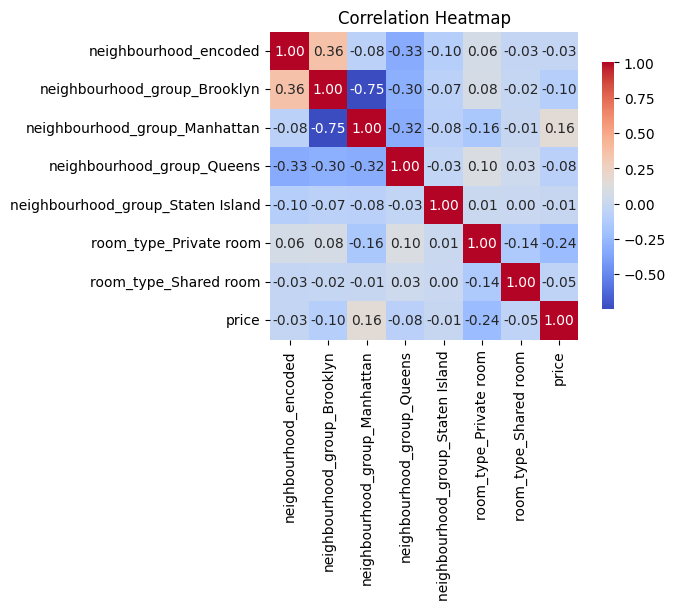

In [242]:
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap')

### Predicting room price

Predicting price is an example of regression problem in wchich we have to assign a number from continous range based on set of features. I'm  going to test and compare various algorithms for this task.

First I'll remove outliers (airbnb with extremaly high prices). Some algorithms I will use later are prone to outliers so it's I have to address this problem somehow. To filtering my data I'll use DBSCAN algorythm.

In [243]:
db = DBSCAN(eps=0.4, min_samples=2)  
data['dbscan_outlier'] = db.fit_predict(data[['price']])
outliers = data[data['dbscan_outlier'] == -1]
non_outliers = data[data['dbscan_outlier'] == 1]
data_cropped = data[data['dbscan_outlier'] != -1]

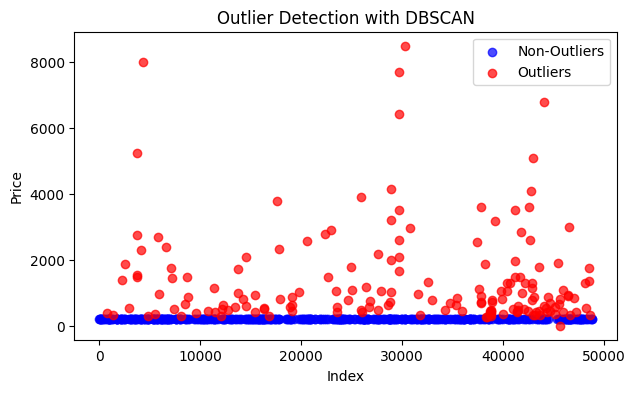

In [245]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.scatter(non_outliers.index, non_outliers['price'], label='Non-Outliers', color='blue', alpha=0.7)
plt.scatter(outliers.index, outliers['price'], label='Outliers', color='red', alpha=0.7)

plt.title('Outlier Detection with DBSCAN')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()

In [254]:
feature_columns = encoded_columns + numerical_features
X = data_cropped[feature_columns]
y = data_cropped['price']

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [256]:
sklearn_models_to_test = {"ridge": Ridge(alpha=1.0),
                          "random_forest": RandomForestRegressor(n_estimators=100),
                          "gradient_boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42),
                          "xgboost_regressor": XGBRegressor(n_estimators=100, learning_rate=0.1, early_stopping=5, silence=False)}

In [257]:
for name, model in sklearn_models_to_test.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    r2 = r2_score(y_test, y_pred)
    print(name)
    print(f"RMSE: {np.sqrt(mse)}, R^2: {r2}.")

ridge
RMSE: 215.5107825593211, R^2: 0.09247880080337345.
random_forest
RMSE: 212.86116264031605, R^2: 0.1146568514700812.
gradient_boosting
RMSE: 194.24928458662515, R^2: 0.26271121667706154.
xgboost_regressor
RMSE: 206.88587524915508, R^2: 0.1636645793914795.


D:\PythonEnvs\study\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "early_stopping", "silence" } are not used.

  warnings.warn(smsg, UserWarning)


Among the proposed methods, the GradientBoostingRegressor performs the best on the test set. Future work should focus on hyperparameter tuning and feature selection.